# Atividade Prática 1 - Agrupamento Nebuloso

## Sistemas Nebulosos - EE/UFMG 2020/2

**Alunos:** 

    Daniel Piçarro

    Jesimon Barreto

#### Pacotes usados

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from functools import partial
import random
#import cv2
from PIL import Image
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import copy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

%matplotlib inline

## Funções usadas

#### Carregar as fotos
Carrega a foto, reescalona (resize) e retorna o seu formato em RGB.

In [3]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

#### Carregar os pixels RGB da imagem

retorna um DataFrame com as coordenadas RGB da imagem.

In [4]:
def pick_pixels(photo):
    n , m = photo.size
    ibagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            ibagem.append(list(pixels[i,j]))
    return pd.DataFrame(ibagem)

#### Colorir a imagem
Colore a imagem com as respectivas cores dos centroides. 

In [5]:
def coloring(photo, labels, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            numb = [int(number) for number in centers[labels[i*m + j]] ] 
            pixels[i,j]= tuple(numb)
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

#### Carregar dados e Plot 2D e 3D

In [6]:
def import_data():
    data = loadmat('fcm_dataset.mat')
    data = pd.DataFrame(data['x'])
    lendata = len(data)
    print('Numero de obervacoes: ', lendata)
    nfeatures = data.shape[1]
    print('Numero de atributos (features): ', nfeatures)

    return data.values#.transpose()

def reduc_samples(X,n_samples=10):
    return X[:n_samples, :]

def plot_samples(x, u, centroids):
    y_kmeans = np.argmax(u, axis=1)
    plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
    plt.show()

def plot_samples3D(x, u, centroids):
    y_ = np.argmax(u, axis=1)
    target_names = ['Red','Green','Blue']
    colors = ['navy', 'turquoise', 'darkorange']
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2], 
                c=y_, cmap='viridis',
                edgecolor='k', s=40, alpha = 0.1)


    ax.set_title("RGB information Fuzzy Kmeans")
    ax.set_xlabel("Red")
    ax.set_ylabel("Green")
    ax.set_zlabel("Blue")
    ax.dist = 10

    for cent in centroids:
        ax.scatter(cent[0],cent[1], cent[2], 
               s = 500, c = 'r', marker='*',alpha = 1.,label = 'Centroid')

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()

### Algoritmo Fuzzy K means

*Observações importantes:*
1. Na implementação da função ```update_u```, é importante ressaltar a normalização ```sum_ = np.sum(U_new[j])```.  Isso, pois, caso não fosse implementada, **a soma dos valores de pertencimento de determinada amostra em relação aos K clusters**, quando somados, **seriam maiores que 1**. Dessa forma, o nossos algoritmo não convergiria. 

2. Na função ```fuzzy_k_means```, jogamos uma exceção caso o parâmetro ```m``` for menor que 1. Isso, tendo em vista que, durante a atualização de U, existe o expoente ```(2/(m - 1))```. Dessa forma, evitamos que haja devisão por 0.  

In [7]:
# gera matriz U aleatória
def generate_u(k: int, n: int):
    return np.random.dirichlet(np.ones(k), size=n)


# retorna array de K centroides 
def calc_centroids(U, X, m):
    centroids = []
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    for i in range(n_centroids):
        u_i = U[:,i] 
        ui_m = u_i ** m

        features_cent = []
        n_feat_cent = int(X.shape[1])
        for feat in range(n_feat_cent):
            x_feat = X[:,feat]
            feat_cent = np.sum((ui_m*x_feat))/np.sum(ui_m) 
            features_cent.append(feat_cent)
        centroids.append(features_cent)

    centroids = np.array(centroids)
    return centroids


# Calcula custo J
def calc_cost(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    cost = 0

    for i in range(n_centroids):
        for j in range(n_samples):
            dist = distance.euclidean(centroids[i], X[j,:])
            cost += (U[j][i] ** m) * (dist ** 2)

    return cost


# Atualiza matriz U
def update_u(U, X, centroids, m):
    n_centroids = U.shape[1]
    n_samples = U.shape[0]

    U_new = copy.copy(U)

    for j in range(n_samples):
        dist_kj = 0
        for k in range(n_centroids):
            dist_kj += distance.euclidean(centroids[k], X[j,:])
        for i in range(n_centroids):
            dist_ij = distance.euclidean(centroids[i], X[j,:])
            U_new[j][i] = 1 / (dist_ij / dist_kj) ** (2/(m - 1))
        #normalizes values between 0 and 1 for each sample
        sum_ = np.sum(U_new[j])
        U_new[j] = U_new[j]/sum_
    
    return U_new

# x: dataset composto por pontos no plano cartesiano (número de dimensões arbitrário)
# n_centroides: número desejado de clusters
# m: exponente de peso (controla o quão fuzzy o cluster será)
def fuzzy_k_means(x, n_centroides, m, threshold = 0.001, max_inter = 10, plot='no' , log = False):
    if m <= 1:
        raise Exception(" 'm' should be greater than 1")

    u = generate_u(n_centroides, x.shape[0])
    cost = 1
    centroids = []
    iterations = 0
    while cost > threshold and iterations < max_inter:
        print('Interação {}'.format(iterations+1))
        centroids = calc_centroids(u, x, m)
        cost = calc_cost(u, x, centroids, m)
        u = update_u(u, x, centroids, m)
        iterations += 1
        print('Erro : {}'.format(cost))
        if log:
            print('Matrix centroids: {}'.format(centroids))
            print('Matrix U: {}'.format(u))
        if plot == '2D':
            plot_samples(x, u, centroids)
        elif plot == '3D':
            plot_samples3D(x, u, centroids)

    
    return {'centroids': centroids, 'u_matrix': u, 'n_iterations': iterations}

### Executando algoritmo para dados 2D

Em seguida, demonstramos o funcionamento do algortimo para amostra de pontos 2D, usando os seguintes parâmetros:
1. número de centróides K = 4
2. expoente de peso m = 2
3. threshold = 0.1
4. Máximo de iterações = 13

#### Resultado obtido: 
Nos gráficos, os pontos pretos são os centróides e os pontos coloridos são as amostras. Cada cor representa um cluster.

De acordo com o resultado obtido, vemos que nosso custo, que se iniciou em **204.8652483183953**, convergiu para **12.433500288327458** em **12 iterações**.

Numero de obervacoes:  800
Numero de atributos (features):  2
Interação 1
Erro : 201.12721175293578


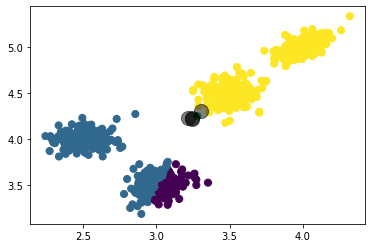

Interação 2
Erro : 124.37244227656005


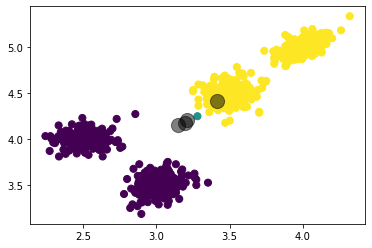

Interação 3
Erro : 104.99817348543331


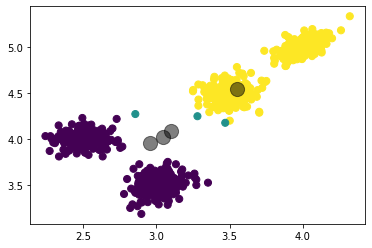

Interação 4
Erro : 78.16643090825038


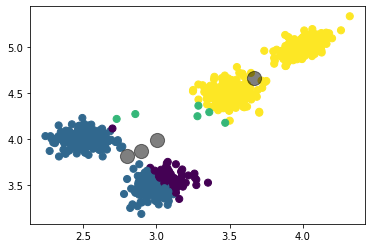

Interação 5
Erro : 64.71688566371915


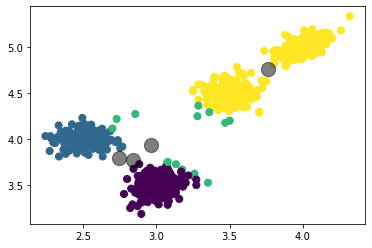

Interação 6
Erro : 57.675887380028094


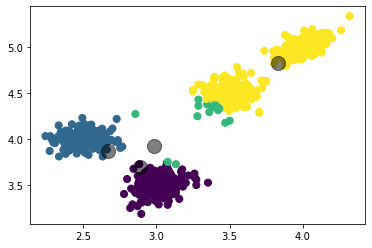

Interação 7
Erro : 47.07862582346519


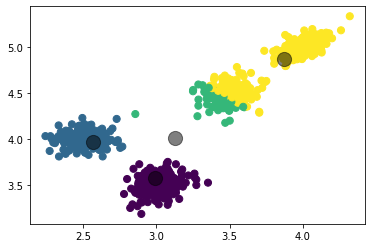

Interação 8
Erro : 32.00845181369862


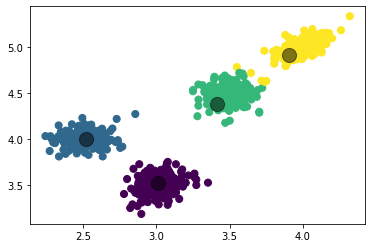

Interação 9
Erro : 13.587175852766435


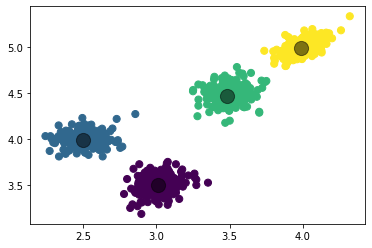

Interação 10
Erro : 12.458786276723373


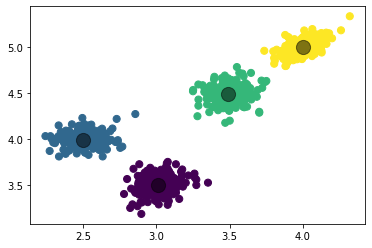

Interação 11
Erro : 12.434092685282657


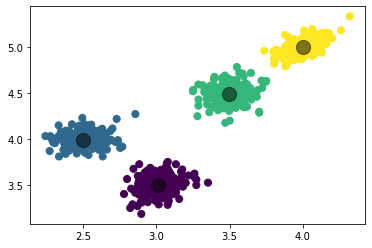

Interação 12
Erro : 12.433509246592177


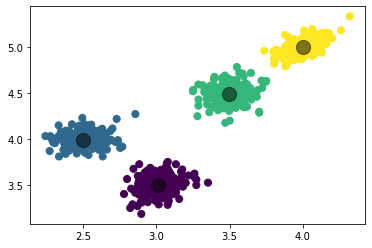

Interação 13
Erro : 12.433494896043687


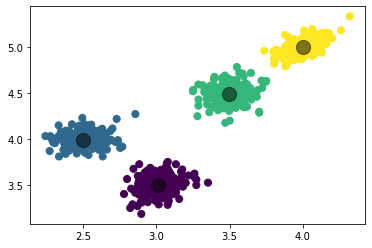

Resultado
Centroides: [[3.01197657 3.49987739]
 [2.50120242 3.99164121]
 [3.49397692 4.48755142]
 [4.00142593 5.00403367]]
Número de interações: 13
Matriz U: [[5.28516760e-03 5.35917454e-03 2.71455190e-02 9.62210139e-01]
 [1.36976957e-02 1.43494988e-02 1.20849720e-01 8.51103086e-01]
 [1.91110800e-03 1.83203280e-03 1.22022546e-02 9.84054605e-01]
 ...
 [2.89296491e-03 9.95482476e-01 1.17169366e-03 4.52865903e-04]
 [5.71100054e-03 9.91073437e-01 2.31181182e-03 9.03751079e-04]
 [2.08235953e-02 9.65203782e-01 9.96391890e-03 4.00870370e-03]]


In [8]:
X = import_data()
result = fuzzy_k_means(X, 4, 2, 0.1, 13, plot = '2D', log = False)
print('Resultado')
print('Centroides: {}'.format(result['centroids']))
print('Número de interações: {}'.format(result['n_iterations']))
print('Matriz U: {}'.format(result['u_matrix']))

### Execução do algoritmo para conjunto de imagens

Finalmente, executamos o agrupamento nebuloso para as imagens disponibilizadas.
Para isso, usamos os seguintes parâmetros na função ```python fuzzy_k_means```
1. número de centróides K = 4
2. expoente de peso m = 2
3. threshold = 0.1
4. Máximo de iterações = 15

#### Resultado obtido: 
Nos resultados, podemos observar, em sequência:
 - A imagem original
 - Erros de cada uma das iterações do algoritmo
 - O gráfico mostrando as amostras (pontos coloridos) e centróides (estrelas vermelhas) referente ao resultado final.  (É importante ressaltar que para colorir as amostras de diferentes cores nos gráficos, usamos o valor de pertencimento mais alto de determinada amostra em relação a todos os clusters)
 - Imagem após ser clusterizada
 
Conclui-se que nossa implementação tem um resultado quantitativo bom e, caso haja o aumento do número de iterações, o resultado pode melhorar ainda mais.



Load and Preprocessing image: photo011.png...


Real image:


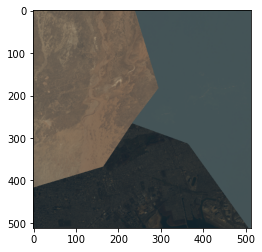

Size pixels: (262144, 3)

Running Fuzzy kmeans for photo011.png

Interação 1
Erro : 207046663.5769388
Interação 2
Erro : 129333357.25699113
Interação 3
Erro : 129319039.09771451
Interação 4
Erro : 129227326.40060087
Interação 5
Erro : 128639290.95620744
Interação 6
Erro : 124882927.57994251
Interação 7
Erro : 103231640.13523968
Interação 8
Erro : 42416584.8662489
Interação 9
Erro : 14059998.4319821
Interação 10
Erro : 13377400.066976754
Interação 11
Erro : 13364338.629371995
Interação 12
Erro : 13357292.056406239
Interação 13
Erro : 13284191.207980312
Interação 14
Erro : 12661275.770154696
Interação 15
Erro : 10619045.503677057
Result Fuzzy kmeans RGB:



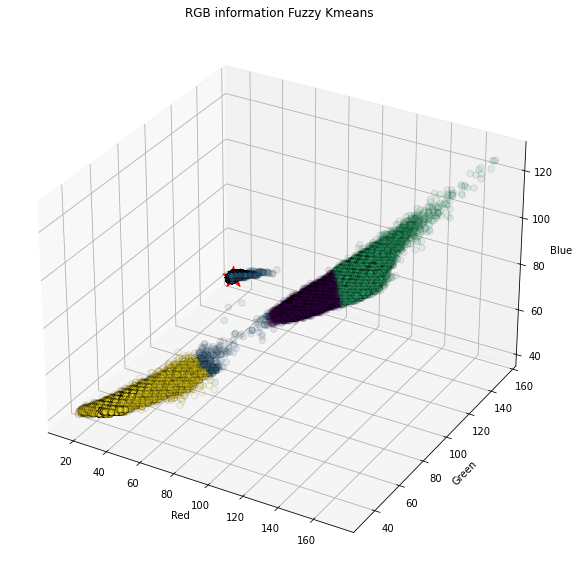



Result for image photo011.png



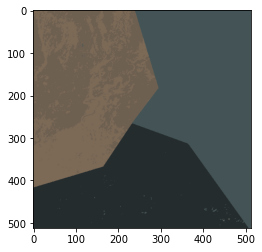



Load and Preprocessing image: photo003.jpg...


Real image:


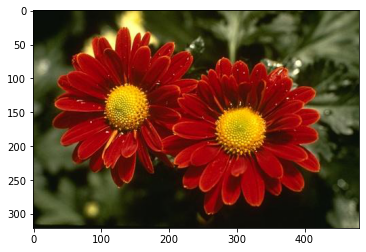

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo003.jpg

Interação 1
Erro : 445726925.21510386
Interação 2
Erro : 278951729.15906847
Interação 3
Erro : 278941875.2847932
Interação 4
Erro : 278899065.80061287
Interação 5
Erro : 278699372.50685453
Interação 6
Erro : 277736805.16245896
Interação 7
Erro : 273280187.29802233
Interação 8
Erro : 257332391.7139286
Interação 9
Erro : 226625102.36012876
Interação 10
Erro : 187960965.81015885
Interação 11
Erro : 159674672.48539937
Interação 12
Erro : 148070268.68801376
Interação 13
Erro : 142646141.48881772
Interação 14
Erro : 139882709.08477056
Interação 15
Erro : 138470930.2084459
Result Fuzzy kmeans RGB:



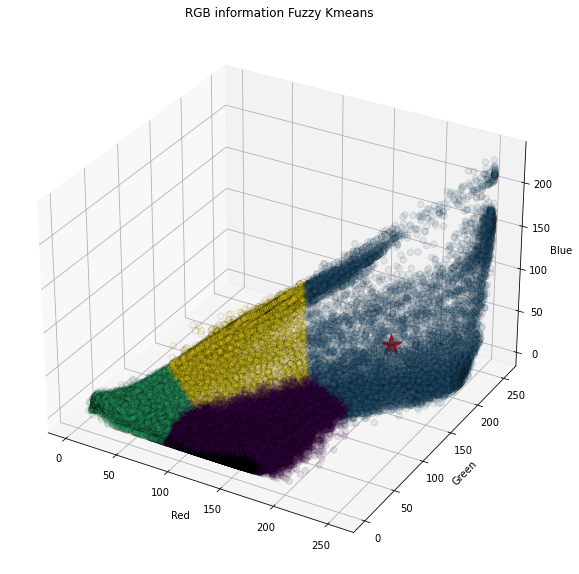



Result for image photo003.jpg



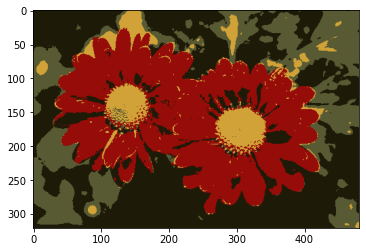



Load and Preprocessing image: photo008.jpg...


Real image:


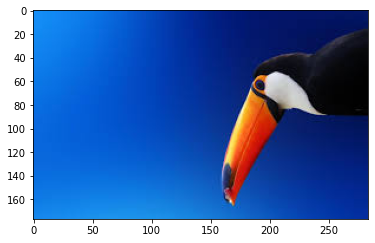

Size pixels: (50268, 3)

Running Fuzzy kmeans for photo008.jpg

Interação 1
Erro : 174030139.73146325
Interação 2
Erro : 109333509.46206042
Interação 3
Erro : 109272176.204237
Interação 4
Erro : 108750089.52030417
Interação 5
Erro : 105033297.77620831
Interação 6
Erro : 92085742.76601915
Interação 7
Erro : 79735785.89120296
Interação 8
Erro : 75060990.33971672
Interação 9
Erro : 72442004.44201969
Interação 10
Erro : 69852156.78274189
Interação 11
Erro : 66392067.8828042
Interação 12
Erro : 62651901.50364492
Interação 13
Erro : 61413368.16864863
Interação 14
Erro : 61231461.229917236
Interação 15
Erro : 61196001.01545156
Result Fuzzy kmeans RGB:



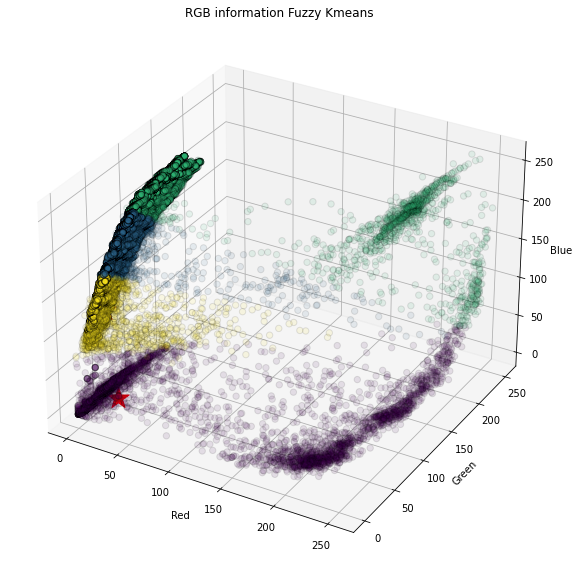



Result for image photo008.jpg



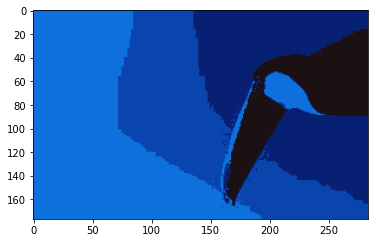



Load and Preprocessing image: photo004.jpg...


Real image:


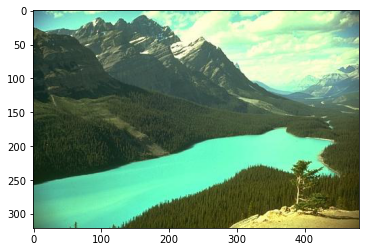

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo004.jpg

Interação 1
Erro : 945715682.5399675
Interação 2
Erro : 590965538.2871859
Interação 3
Erro : 590283343.5894389
Interação 4
Erro : 581920910.6588291
Interação 5
Erro : 500987927.798017
Interação 6
Erro : 266119360.2640457
Interação 7
Erro : 203922918.20308504
Interação 8
Erro : 198101667.66794714
Interação 9
Erro : 183642948.54438803
Interação 10
Erro : 156255385.75660953
Interação 11
Erro : 134165504.57028483
Interação 12
Erro : 130438053.00231889
Interação 13
Erro : 130056204.92290919
Interação 14
Erro : 129974597.26598889
Interação 15
Erro : 129945426.724435
Result Fuzzy kmeans RGB:



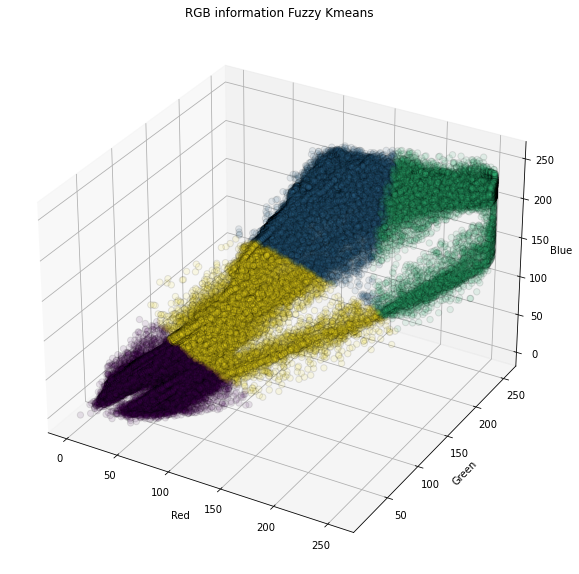



Result for image photo004.jpg



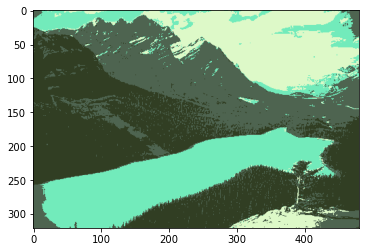



Load and Preprocessing image: photo005.jpg...


Real image:


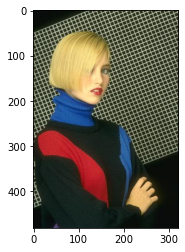

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo005.jpg

Interação 1
Erro : 785953385.9046713
Interação 2
Erro : 491228124.2850912
Interação 3
Erro : 490970338.65817046
Interação 4
Erro : 488023383.5210235
Interação 5
Erro : 459975388.0165924
Interação 6
Erro : 334628852.20367855
Interação 7
Erro : 207154500.07853663
Interação 8
Erro : 171581289.68269616
Interação 9
Erro : 163478061.24163938
Interação 10
Erro : 160776704.89842784
Interação 11
Erro : 159265139.51165777
Interação 12
Erro : 158164189.5033573
Interação 13
Erro : 157287285.12954423
Interação 14
Erro : 156572640.47242483
Interação 15
Erro : 155989069.23535118
Result Fuzzy kmeans RGB:



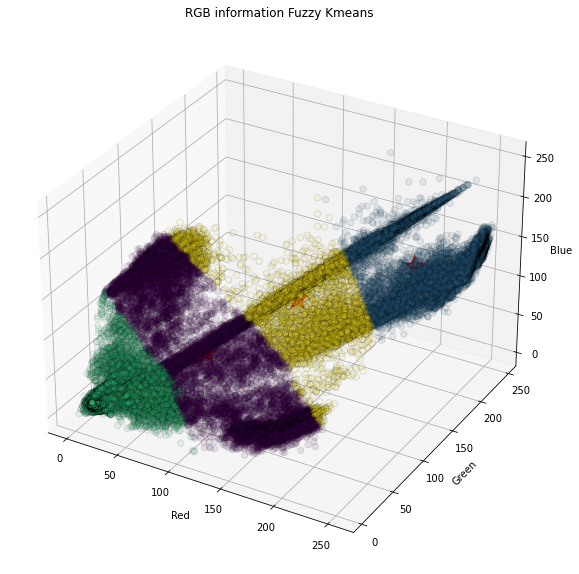



Result for image photo005.jpg



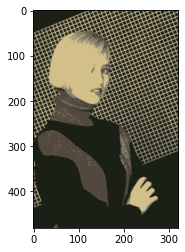



Load and Preprocessing image: photo006.jpg...


Real image:


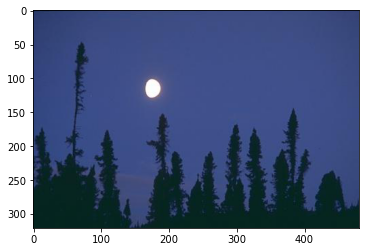

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo006.jpg

Interação 1
Erro : 172653825.0594742
Interação 2
Erro : 108330687.79884562
Interação 3
Erro : 108008757.80684099
Interação 4
Erro : 103546517.06215613
Interação 5
Erro : 69379893.46555655
Interação 6
Erro : 26211524.6438588
Interação 7
Erro : 20145629.460259113
Interação 8
Erro : 19826684.600309275
Interação 9
Erro : 19815085.94208781
Interação 10
Erro : 19814249.44192497
Interação 11
Erro : 19813970.617611386
Interação 12
Erro : 19813806.18662723
Interação 13
Erro : 19813699.13530365
Interação 14
Erro : 19813626.862425063
Interação 15
Erro : 19813577.019538753
Result Fuzzy kmeans RGB:



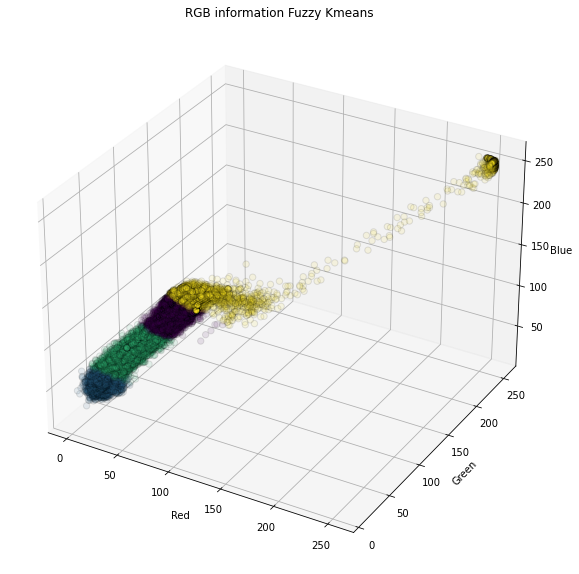



Result for image photo006.jpg



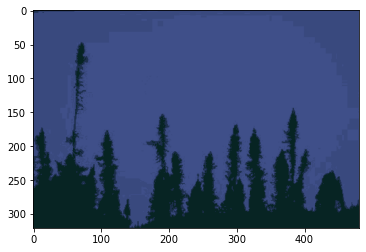



Load and Preprocessing image: photo007.jpg...


Real image:


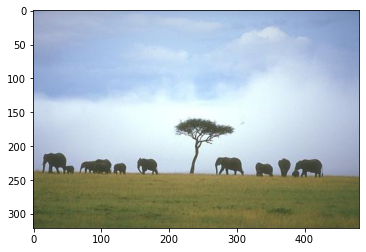

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo007.jpg

Interação 1
Erro : 668030184.0061814
Interação 2
Erro : 416871481.2421525
Interação 3
Erro : 416802803.39004475
Interação 4
Erro : 415987335.8906257
Interação 5
Erro : 406574074.78728676
Interação 6
Erro : 324093077.6972089
Interação 7
Erro : 135825033.93021667
Interação 8
Erro : 105558481.32133853
Interação 9
Erro : 98246497.1412549
Interação 10
Erro : 79824075.46264409
Interação 11
Erro : 68182644.71951404
Interação 12
Erro : 66031675.54757851
Interação 13
Erro : 65785776.38984791
Interação 14
Erro : 65746722.74972916
Interação 15
Erro : 65734043.0381047
Result Fuzzy kmeans RGB:



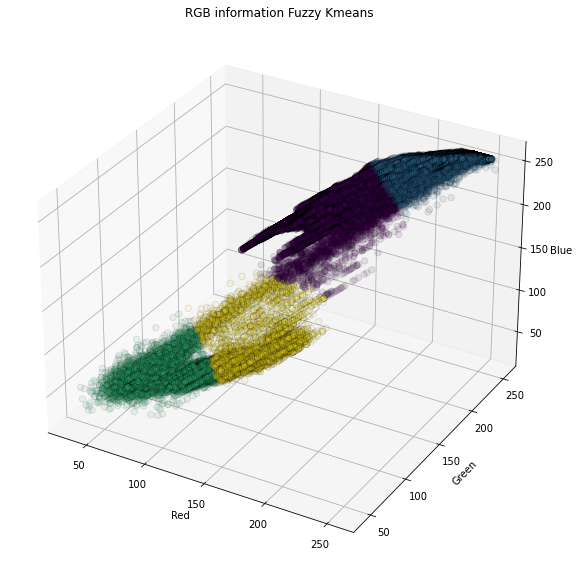



Result for image photo007.jpg



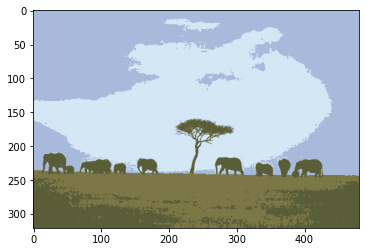



Load and Preprocessing image: photo009.jpg...


Real image:


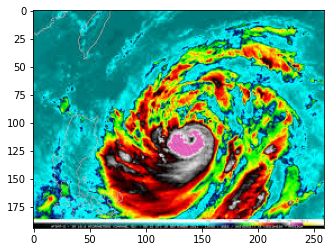

Size pixels: (50246, 3)

Running Fuzzy kmeans for photo009.jpg

Interação 1
Erro : 416205653.7065012
Interação 2
Erro : 260590895.4698322
Interação 3
Erro : 260590489.62507284
Interação 4
Erro : 260589657.19995046
Interação 5
Erro : 260586427.43806797
Interação 6
Erro : 260570934.00028384
Interação 7
Erro : 260491969.25747085
Interação 8
Erro : 260087682.94252205
Interação 9
Erro : 258122202.77325118
Interação 10
Erro : 250459474.5204355
Interação 11
Erro : 233237726.57881188
Interação 12
Erro : 215732542.46640953
Interação 13
Erro : 208529641.9092261
Interação 14
Erro : 204369386.4153643
Interação 15
Erro : 195130226.8012895
Result Fuzzy kmeans RGB:



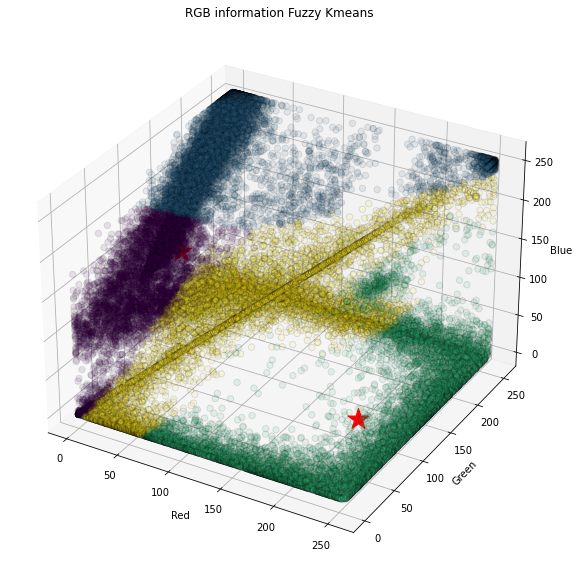



Result for image photo009.jpg



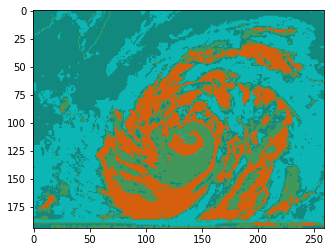



Load and Preprocessing image: photo002.jpg...


Real image:


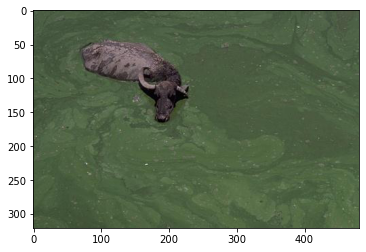

Size pixels: (154401, 3)

Running Fuzzy kmeans for photo002.jpg

Interação 1
Erro : 27823341.48474997
Interação 2
Erro : 17372781.799768467
Interação 3
Erro : 17355966.400685515
Interação 4
Erro : 17221856.644129787
Interação 5
Erro : 16589121.077131981
Interação 6
Erro : 15597226.517378533
Interação 7
Erro : 14963733.031872
Interação 8
Erro : 14539485.146648597
Interação 9
Erro : 14224154.000803228
Interação 10
Erro : 14032191.009998364
Interação 11
Erro : 13918352.854433442
Interação 12
Erro : 13845670.342079392
Interação 13
Erro : 13796637.721283235
Interação 14
Erro : 13762348.747030165
Interação 15
Erro : 13737636.211198594
Result Fuzzy kmeans RGB:



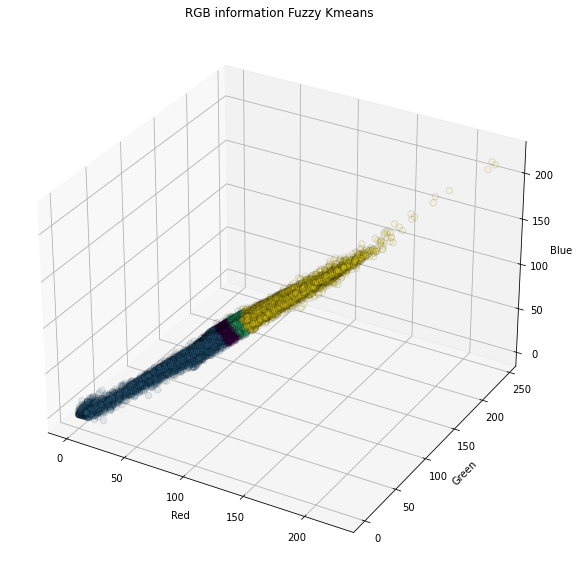



Result for image photo002.jpg



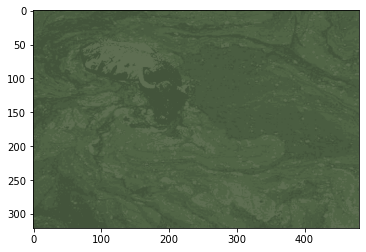



Load and Preprocessing image: photo001.jpg...


Real image:


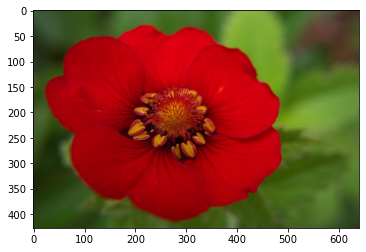

Size pixels: (273280, 3)

Running Fuzzy kmeans for photo001.jpg

Interação 1
Erro : 696386789.0478977
Interação 2
Erro : 435470436.01739335
Interação 3
Erro : 435393057.19952935
Interação 4
Erro : 434626121.1807894
Interação 5
Erro : 427254752.8642296
Interação 6
Erro : 372539903.31149703
Interação 7
Erro : 243491471.0481088
Interação 8
Erro : 210014863.83220837
Interação 9
Erro : 201925018.02864766
Interação 10
Erro : 197619681.9771729
Interação 11
Erro : 189473451.89766216
Interação 12
Erro : 178293669.02612916
Interação 13
Erro : 171370137.52451262
Interação 14
Erro : 167945861.87335166
Interação 15
Erro : 165949424.85101837
Result Fuzzy kmeans RGB:



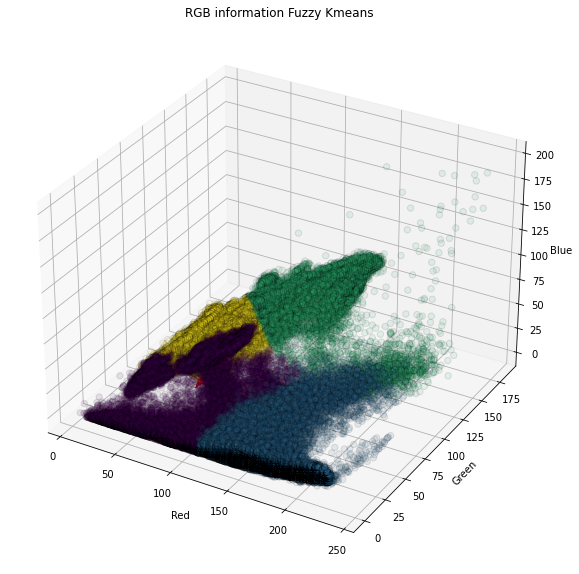



Result for image photo001.jpg



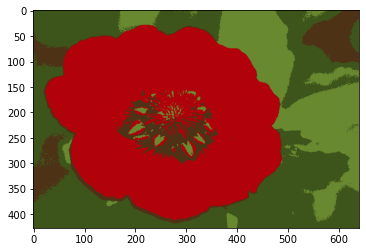



Load and Preprocessing image: photo010.jpg...


Real image:


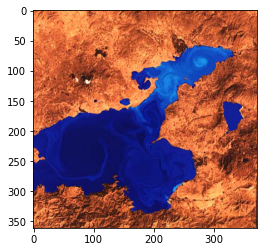

Size pixels: (133931, 3)

Running Fuzzy kmeans for photo010.jpg

Interação 1
Erro : 691034254.9078181
Interação 2
Erro : 432498124.82488686
Interação 3
Erro : 432473727.1439671
Interação 4
Erro : 432256663.7471523
Interação 5
Erro : 430357839.79904735
Interação 6
Erro : 415313866.8854109
Interação 7
Erro : 341843801.8651694
Interação 8
Erro : 233047131.22906315
Interação 9
Erro : 172055706.5294026
Interação 10
Erro : 153126979.27017558
Interação 11
Erro : 142654898.90392774
Interação 12
Erro : 134321908.60251105
Interação 13
Erro : 129635044.637341
Interação 14
Erro : 127261105.69869508
Interação 15
Erro : 125949939.83354396
Result Fuzzy kmeans RGB:



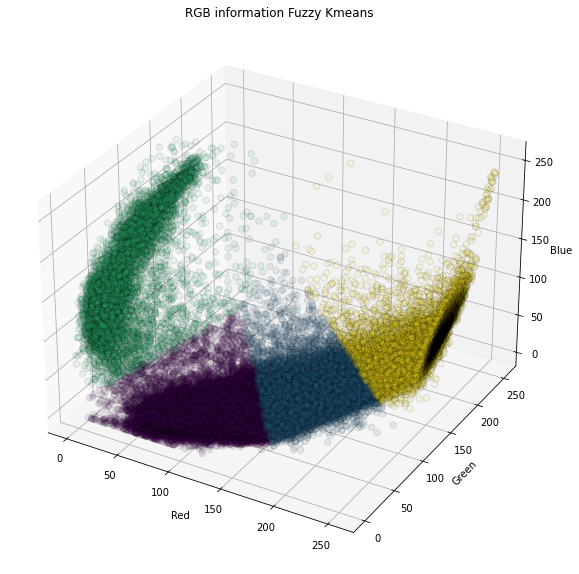



Result for image photo010.jpg



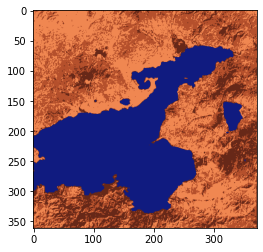

In [14]:
path_images = './ImagensTeste/'
filenames = os.listdir(path_images)
n_inter = 15
error_acc = 0.1
k = 4
m = 2
log = False

for filename in filenames:
    print('\n\nLoad and Preprocessing image: {}...\n'.format(filename))
    
    #load image and transform in vector RGB
    photo = photo_open(path_images+filename)
    print('\nReal image:')
    plt.imshow(photo)
    plt.show()
    pixels = pick_pixels(photo).values
    print('Size pixels: {}\n'.format(pixels.shape))
    
    #running the Fuzzy kmeans algorithm
    print('Running Fuzzy kmeans for {}\n'.format(filename))
    result = fuzzy_k_means(pixels, k, m, error_acc, n_inter, plot = 'no', log = log)
    
    #Plot result de categorização do algoritmo
    print('Result Fuzzy kmeans RGB:\n')
    plot_samples3D(pixels, result['u_matrix'], result['centroids'])
    
    #transforma de valores retornados pelo fuzzy em um vetor de labels
    print('\n\nResult for image {}\n'.format(filename))
    labels = np.argmax(result['u_matrix'],axis=1)
    centers = result['centroids']
    photo = coloring(photo, labels, centers)
    
    #Plot result
    plt.imshow(photo)
    plt.show()